In [1]:
import pandas as pd
import numpy as np
import nltk
nltk.download('punkt')
nltk.download('wordnet')
from sklearn.feature_extraction.text import CountVectorizer
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import re
from sklearn.metrics.pairwise import cosine_similarity
from sentence_transformers import SentenceTransformer
import matplotlib.pyplot as plt
import seaborn as sns
!gdown https://drive.google.com/uc?id=1vbteMX-kHyYAAS7JIrrog_aZvvOY77Q0

[nltk_data] Downloading package punkt to /Users/sokyang/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/sokyang/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Downloading...
From (original): https://drive.google.com/uc?id=1vbteMX-kHyYAAS7JIrrog_aZvvOY77Q0
From (redirected): https://drive.google.com/uc?id=1vbteMX-kHyYAAS7JIrrog_aZvvOY77Q0&confirm=t&uuid=a5464b95-32ce-4127-a346-fb248484a8e1
To: /Users/sokyang/Desktop/bt4222/final_dataset.csv
100%|████████████████████████████████████████| 456M/456M [01:38<00:00, 4.62MB/s]


# **Load Dataset**

In [2]:
data = pd.read_csv('final_dataset.csv', dtype = {'Movie': 'string', 'Reviewer': 'string', 'Review': 'string', 'Score': 'float64', 'Sentiment_scores': 'float64', 'overview': 'string', 'recommend': 'int'}, parse_dates=['Date'])
print(data.columns)
print(data.head())

Index(['Movie', 'Reviewer', 'Review', 'Score', 'Sentiment_scores', 'overview',
       'cast_list', 'crew_list', 'director_list', 'first_three_casts',
       'unique_genres', 'Date', 'recommend'],
      dtype='object')
       Movie          Reviewer  \
0  SENSATION   Dennis Schwartz   
1  SENSATION  Carey-Ann Pawsey   
2  SENSATION        Rob Rector   
3  SENSATION        Rich Cline   
4  SENSATION       Allen Adams   

                                              Review     Score  \
0  A sci-fi film that made no sense, as it tells ...  0.686869   
1  A thriller that ultimately makes little to no ...  0.393939   
2  There's still much to admire with Sensation, d...  0.595960   
3  There's no thematic depth in the story or char...  0.494949   
4  Sensation wants to be a deep movie...[but] tho...  0.393939   

   Sentiment_scores                                           overview  \
0          0.276348  Man-boy farmer Donal discovers that his father...   
1          0.334176  Man-boy far

# **Data Processing**

*   create a dataset of unique movies
*   preprocess overview

In [3]:
#keep only unique movies
unique_movies = data.drop_duplicates(subset='Movie')
unique_movies = unique_movies.reset_index()

#preprocess overview
def process_text(text):
    processed_text = ""
    lower_text = text.lower()
    tokenized_text = word_tokenize(lower_text)
    alphabetic_tokens = [token for token in tokenized_text if re.match('^[a-zA-Z]+$', token)]
    lemmatized_words = [WordNetLemmatizer().lemmatize(token) for token in alphabetic_tokens]
    processed_text = ' '.join(lemmatized_words)
    return processed_text

unique_movies['processed_overview'] = unique_movies['overview'].apply(lambda x: process_text(x))




*   convert genres to lower case and combine into 1 string
*   convert director list to lower case, join first and last name, combine into 1 string
*   convert first 3 casts to lower case, join first and last name, combine into 1 string

In [4]:
#convert genres to lowercase and combine into 1 long string
unique_movies['unique_genres'] = unique_movies['unique_genres'].apply(lambda x: eval(x))
unique_movies['processed_genres'] = unique_movies['unique_genres'].apply(lambda x: ' '.join([word.lower() for word in x]))
print(unique_movies['processed_genres'])

#convert director list to lower case, join first and last name, combine into 1 long string
unique_movies['director_list'] = unique_movies['director_list'].apply(lambda x: eval(x))

def process_names(names_list):
  processed_names = [''.join(name.lower().split()) for name in names_list]
  return ' '.join(processed_names)

unique_movies['processed_directors'] = unique_movies['director_list'].apply(lambda x: process_names(x))
print(unique_movies['processed_directors'])

#convert first 3 casts to lower case, join first and last name, combine into 1 long string
unique_movies['first_three_casts'] = unique_movies['first_three_casts'].apply(lambda x: eval(x))
unique_movies['processed_cast'] = unique_movies['first_three_casts'].apply(lambda x: process_names(x))
print(unique_movies['processed_cast'])

0       drama romance comedy foreign
1                  drama history war
2                   thriller mystery
3                             comedy
4             drama thriller mystery
                    ...             
5211                          comedy
5212           drama thriller comedy
5213                        thriller
5214       drama history war foreign
5215                  romance comedy
Name: processed_genres, Length: 5216, dtype: object
0                           tomhall
1                     romanpolanski
2                  wolfgangpetersen
3                      chuckvincent
4                  barbarastepansky
                   ...             
5211    jasonfriedberg aaronseltzer
5212                      henrybean
5213                    chrisjaymes
5214                 enniodeconcini
5215                     carlreiner
Name: processed_directors, Length: 5216, dtype: object
0                luannegordon kellycampbell owenroe
1                jonfinch francescaann

# **Count Vectorizer**

*   Combine processed overview, genres, directors and first 3 casts into one string
*   Create a count vectorizer 

In [5]:
#combine overview and genres into 1 long string (soup)
unique_movies['soup'] = unique_movies['processed_overview'] + ' ' + unique_movies['processed_genres'] + ' ' + unique_movies['processed_directors'] + ' ' + unique_movies['processed_cast']
print(unique_movies['soup'][0])

#create a count vectorizer
count_vectorizer = CountVectorizer(analyzer='word', stop_words='english')
count_matrix = count_vectorizer.fit_transform(unique_movies['soup'])

farmer donal discovers that his father ha suddenly passed away now on his own donal attempt to lose his virginity by hiring a prostitute to help him get out of his rut and so he meet kim an aging kiwi escort after engaging in a strictly sexual encounter their relationship soon progress into a lusty romance then to a business enterprise between two partner through these exploit donal and kim provide each other with a sense of love and belonging that neither experienced beforehand drama romance comedy foreign tomhall luannegordon kellycampbell owenroe


# **Bert Model**

*   Combine overview, genres, directors and first 3 casts into one string
*   Create a bert model

In [6]:
#create soup2 for bert
unique_movies['soup2'] = unique_movies['overview'] + ' ' + unique_movies['processed_genres'] + ' ' + unique_movies['processed_directors'] + ' ' + unique_movies['processed_cast']

#create bert model
bert_model = SentenceTransformer('bert-base-nli-mean-tokens')
embeddings = bert_model.encode(unique_movies["soup2"], show_progress_bar=True)

Batches:   0%|          | 0/163 [00:00<?, ?it/s]

# **Cosine Similarity Scores**

**Create cosine scores for the matrix derived from the count vectorizer and the embedding from the BERT model**

In [7]:
#calculate cosine similarity
cosine_scores = cosine_similarity(count_matrix)
cosine_scores_bert = cosine_similarity(embeddings)

# Flatten the cosine similarity matrix into a 1D array
cosine_scores_flat = cosine_scores.flatten()
cosine_scores_bert_flat = cosine_scores_bert.flatten()

**Compare densities of cosine similarity scores derived from BERT and from count vectorizer**

- Cosine similarity scores derived from BERT will be used in our hybrid model as the distribution is much more even.

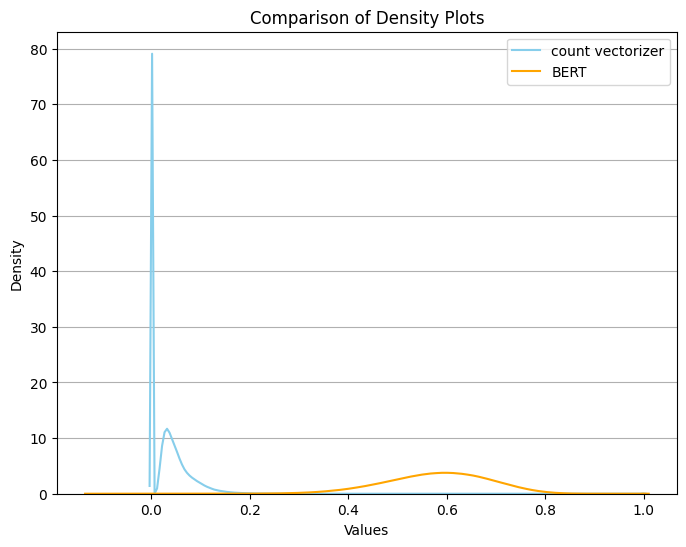

In [8]:
# Plot a density plot
plt.figure(figsize=(8, 6))
sns.kdeplot(cosine_scores_flat, color='skyblue', label='count vectorizer')
sns.kdeplot(cosine_scores_bert_flat, color='orange', label='BERT')
plt.title('Comparison of Density Plots')
plt.xlabel('Values')
plt.ylabel('Density')
plt.legend()
plt.grid(axis='y')
plt.show()

# **Top-K Recommendations**

In [9]:
#content based filtering method
def recommend_movies(movie, cosine_scores, unique_movies, top_n=10):
    movie_index = unique_movies[unique_movies['Movie'] == movie].index[0]
    sim_scores = list(enumerate(cosine_scores[movie_index]))
    sim_scores.sort(key=lambda x: x[1], reverse=True)

    # Get top n similar movies (excluding the input movie itself)
    top_movies = sim_scores[1:top_n + 1]

    # Extract movie titles from indices
    recommended_movies = [(unique_movies.iloc[i]['Movie'], cosine_scores[movie_index][i]) for i, _ in top_movies]

    return recommended_movies

Recommendations with Count Vectorizer

In [10]:
#test content based filtering
recommended_movies = recommend_movies('INTERSTELLAR', cosine_scores, unique_movies)
print(pd.DataFrame(recommended_movies, columns = ['Movie', 'Cosine_Scores']))

                  Movie  Cosine_Scores
0       PASSAGE TO MARS       0.248734
1          MEGA PIRANHA       0.227921
2  THE SPACE BETWEEN US       0.211100
3      MIDNIGHT SPECIAL       0.211100
4            PROMETHEUS       0.201008
5       ROBOT OVERLORDS       0.199681
6         THE WOLVERINE       0.194625
7     FROM TIME TO TIME       0.193952
8             MAX STEEL       0.190693
9         THE WILD HUNT       0.189934


Recommendations with Bert Model

In [11]:
#test content based filtering
recommended_movies = recommend_movies('INTERSTELLAR', cosine_scores_bert, unique_movies)
print(pd.DataFrame(recommended_movies, columns = ['Movie', 'Cosine_Scores_Bert']))

                           Movie  Cosine_Scores_Bert
0                     PROMETHEUS            0.866442
1               STAR TREK BEYOND            0.856962
2                RATCHET & CLANK            0.841057
3        APPROACHING THE UNKNOWN            0.834512
4   ROGUE ONE: A STAR WARS STORY            0.828725
5                 FANTASTIC FOUR            0.828568
6            ABSOLUTELY ANYTHING            0.823955
7  STARSHIP TROOPERS 3: MARAUDER            0.820990
8                       IRON SKY            0.820149
9                           LIFE            0.820112
